# Analyzing the topic changes and their implications

First, we load the pretrained topic model and the vectors

In [1]:
import numpy as np
from tqdm import tqdm
import sqlite3
import pandas as pd
from collections import defaultdict
from bertopic import BERTopic
from util.sql_switch import get_query_native

#import delab.topic.train_topic_model as tm

bertopic_model = BERTopic().load("BERTopic", embedding_model="sentence-transformers/all-mpnet-base-v2")
topic_info = bertopic_model.get_topic_info()


def topic2wordvec(topic_model):
    result = []
    for t_word in topic_model:
        str_w = t_word[0]
        result.append(str_w)
    return result


# create topic-word map
topic2word = defaultdict(list)
for topic_id in tqdm(topic_info.Topic):
    topic_model = bertopic_model.get_topic(topic_id)
    words = topic2wordvec(topic_model)
    topic2word[topic_id] = topic2word[topic_id] + words
t2w_keys = list(topic2word.keys())[0:3]
for key in t2w_keys:
    print(topic2word[key])

100%|██████████| 15/15 [00:00<00:00, 114390.11it/s]

['is', 'it', 'are', 'they', 'have', 'be', 'what', 'all', 'people', 'just']
['tsla', 'when', 'day', 'calls', 'today', 'will', 'week', 'lower', 'friday', 'options']
['covid', 'vaccine', 'they', 'tested', 'hospitals', 'vaccinated', 'have', 'when', 'than', 'can']


Now we are loading the pre_saved ft vectors from the database!


In [2]:
df_conversations = get_query_native(
    "SELECT id, text, author_id, bertopic_id, conversation_id,sentiment_value,created_at FROM delab_tweet tw where language = 'en' and bertopic_id >= 0")
df_conversations.head(3)

using postgres


,id,text,author_id,bertopic_id,conversation_id,sentiment_value,created_at
0,9530,"@sadi18032311 @BFSF1212 @Ferezarams I guess we must forget the political parties and focus on fixing our own community by any means necessary, Politicians doesn't really care",809110570918170624,6,1452509182670909447,NaN,2021-10-25 09:28:27+00:00
1,9539,"@DlaminiBM @Setlagole_L @Gundo_V @Ferezarams someone said ANC didnt transform SA they transformed Apartheid, Black SAns are living worser than Apartheid easy practical SAns were working during apartheid it was an offense not to work today 12M SAns are reduced to grant recipients",302713191,4,1452509182670909447,NaN,2021-10-25 13:00:59+00:00
2,9538,"@Setlagole_L @Gundo_V @BFSF1212 @Ferezarams Sorry about that, those guys were brutal and the apartheid police turned the blind eye as long as they were terrorising the Black community.",160930678,4,1452509182670909447,NaN,2021-10-25 12:55:49+00:00


In [3]:
pd.set_option('display.max_colwidth', None)
text = df_conversations.head(1).text
print(text)
id = df_conversations.head(1).bertopic_id[0]
bertopic = bertopic_model.get_topic(id)
print(bertopic)

0    @sadi18032311 @BFSF1212 @Ferezarams I guess we must forget the political parties and focus on fixing our own community by any means necessary, Politicians doesn't really care
Name: text, dtype: object
[('democracy', 0.0458736290430674), ('power', 0.04162854075692343), ('party', 0.04162854075692343), ('of', 0.037852231453478935), ('filibuster', 0.03282876345128684), ('are', 0.028310637188557298), ('parliament', 0.02775236050461562), ('sense', 0.02588824839037067), ('first', 0.02391220991979598), ('right', 0.021665865830554066)]


It looks like our topic is matching the tweet.

In [4]:
df_conversations_bad_topic = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id < 0")

df_conversations_total = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id != null")

print(df_conversations.id.size)
print(df_conversations_bad_topic.n[0])
print(df_conversations_total.n[0])

print("From {} tweets {} percent could not be topic labeled".format(df_conversations_total.n[0],
                                                                    df_conversations_bad_topic.n[0] * 100 /
                                                                    df_conversations_total.n[0]))

using postgres
using postgres
440
5330
0
From 0 tweets inf percent could not be topic labeled


/tmp/ipykernel_32052/2529596704.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  df_conversations_bad_topic.n[0] * 100 /


It seems, that our recall is not so great. We favoured the precision over the recall, drastically removing
topics that did not include words in the vocabulary. However, the bert models have good results on the oov-words, too.

More importantly, the high precision and low recall clashes with low precision and high sensitivity from the sentiment analysis.
However, we are continuing for the moment in order to have a look at the results as they stand.

In [5]:
#df_conversations.conversation_id.nunique()
df_reshaped = df_conversations.pivot(index="id", columns="conversation_id", values="text")
mask = 10 > df_reshaped.nunique()
mask = mask[mask == True]
df_reshaped.drop(columns=mask.index, inplace=True)
df_reshaped.nunique()

conversation_id
1449411492021825541    167
1450956635690704899     36
1451256052205379596     17
1451362578060431365     68
1452436776916762629     46
1454589125777104905     25
1455286078693384199     16
dtype: int64

There are only 4 conversations with 10 or more tweets that have a valid topic classification :-(.

Lets' have a look at the relation between sentiment_values and topic_changes!

In [26]:
conversation_corpora_cleaned = {}
conversation_corpora = df_reshaped.to_dict(orient="series")
for conversation_id, tweets in conversation_corpora.items():
    conversation_corpora_cleaned[conversation_id] = tweets.dropna()

useful_conversations_keys = conversation_corpora_cleaned.keys()

useful_conversations = df_conversations[df_conversations["conversation_id"].isin(useful_conversations_keys)]
useful_conversations = useful_conversations.loc[:,
                       ["id", "bertopic_id", "conversation_id", "sentiment_value", "created_at"]]

example_id = df_reshaped.nunique().index[0]
exampleconversation = useful_conversations[useful_conversations.conversation_id == example_id]
exampleconversation.head(3)

,id,bertopic_id,conversation_id,sentiment_value,created_at
4,452,7,1449411492021825541,-3.677237,2021-10-20 08:48:49+00:00
5,540,7,1449411492021825541,-1.853752,2021-10-17 05:50:53+00:00
6,542,7,1449411492021825541,3.937621,2021-10-17 05:47:11+00:00


This conversation seems a good candidate for inspection as it includes drastic topic and sentiment changes.


In [7]:
import json
from scipy import spatial
import numpy as np


# in the productive setting filter this query with "in words contained in the current conversation topics"
word2vec = get_query_native(
    "SELECT word, ft_vector from delab_topicdictionary")

def get_topic_delta(topic_id_1, topic_id_2):
    words1 = topic2word.get(topic_id_1)
    words2 = topic2word.get(topic_id_2)
    if words1 is not None and words2 is not None:
        filtered_w2v1 = word2vec[word2vec["word"].isin(words1)]
        filtered_w2v2 = word2vec[word2vec["word"].isin(words2)]
        ft_vectors_1 = filtered_w2v1.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        ft_vectors_2 = filtered_w2v2.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        len1 = len(ft_vectors_1)
        len2 = len(ft_vectors_2)
        sum_v1 = (ft_vectors_1.sum(axis=0) / len1) # we assume the vectors are embedded in a linear space
        sum_v2 = (ft_vectors_2.sum(axis=0) / len2)
        similarity = spatial.distance.cosine(sum_v1, sum_v2)
        return similarity
    else:
        return np.NaN

exampleconversation.sort_values(by=['created_at'], ascending=True, inplace=True)
exampleconversation.reset_index(drop=True, inplace=True)
exampleconversation["bertopic_shifted"] = exampleconversation.bertopic_id.shift()
exampleconversation["topic_delta"] = exampleconversation.apply(
    lambda x: get_topic_delta(x.bertopic_id, x.bertopic_shifted), axis=1)

exampleconversation.head(5)

using postgres


ValueError: Wrong number of items passed 6, placement implies 1

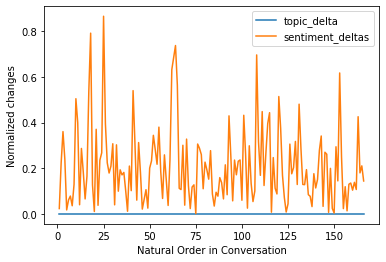

In [35]:
#from sklearn import preprocessing
sv = exampleconversation.sentiment_value
exampleconversation["sentiment_normalized"] = ((sv-sv.min())/(sv.max()-sv.min()))

exampleconversation["sentiment_deltas"] = exampleconversation["sentiment_normalized"].diff().abs()
plot = exampleconversation.plot(y=['topic_delta', "sentiment_deltas"], xlabel = "Natural Order in Conversation", ylabel="Normalized changes", use_index=True)
plot.get_figure().savefig('sentiment_topics.png')

After normalizing, it looks like we can compare the two metrics. However, topic continuation should be
interpreted differently then a continuous sentiment flow.

In order to compute the correlation we need to compute:
- a more precise sentiment classification
- a wider set of conversations with existing topic classifications
- a better metric of the topic flow that takes into account the general frequency of topic  changes and
  can thus highlight conversations with high or low topic volatility